In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
			
import pandas as pd
import numpy as np
from pathlib import Path		

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium
# from folium.plugins import HeatMap
import branca

In [3]:
def create_visualization(df_, date_range_min_, date_rage_max_, col_, percentile = None, radius = 10):
    # note that the color scale is only applied after the data is filtered by percentile
    colorscale = branca.colormap.linear.YlOrRd_09.scale(0, max(df_[col_]))
    df_ = df_.loc[date_range_min_:date_rage_max_]
    if percentile:
        df_ = df_[df_[col_] > np.nanpercentile(df_[col_], percentile)]
       
    m = folium.Map(location = [-36.848461, 174.763336])  #show Auckland
    for long, lat, volume, road in zip(df_['longitude'], df_['latitude'], df_[col_], df_['road_name']):
        folium.CircleMarker(location=(lat, long),
                        popup = f'{road}:{volume}',
                        radius=radius,
                        color=colorscale(volume),
                        fill=True).add_to(m)
    cmap = colorscale.to_step(10)
    cmap.caption = '7 day average traffic count'
    cmap.add_to(m)
#     m.save('Auckland_map.html')
#    m._repr_html_()
    return m

In [4]:
import sklearn

In [5]:
df = pd.read_csv(r'data/merged_date.csv', parse_dates = ['count_date'], index_col = None)
df.set_index('count_date', inplace = True)
# df = df[df.index > '2017-01-01']
df.drop_duplicates(inplace = True)
df.sort_index(inplace = True)
# display_all(df.head())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27031 entries, 1974-07-12 to 2019-04-09
Data columns (total 5 columns):
road_name         27031 non-null object
adt               27031 non-null float64
latitude          27031 non-null float64
longitude         27031 non-null float64
sampling_count    27031 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.2+ MB


{'whiskers': [<matplotlib.lines.Line2D at 0xc9869e8>,
 'caps': [<matplotlib.lines.Line2D at 0xc986e10>,
 'boxes': [<matplotlib.lines.Line2D at 0xc9865c0>],
 'medians': [<matplotlib.lines.Line2D at 0xc9a2748>],
 'fliers': [<matplotlib.lines.Line2D at 0xc9a2a90>],
 'means': []}

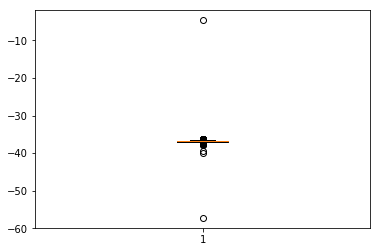

In [6]:
plt.boxplot(df.latitude)

{'whiskers': [<matplotlib.lines.Line2D at 0xca18f98>,
 'caps': [<matplotlib.lines.Line2D at 0xca22908>,
 'boxes': [<matplotlib.lines.Line2D at 0xca18e48>],
 'medians': [<matplotlib.lines.Line2D at 0xca22f98>],
 'fliers': [<matplotlib.lines.Line2D at 0xca2a320>],
 'means': []}

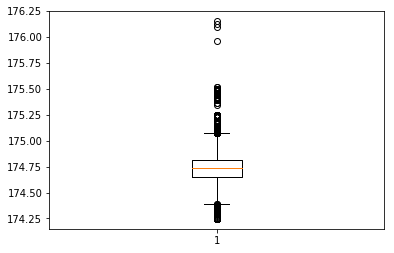

In [7]:
plt.boxplot(df.longitude)

In [8]:
# drop outlier coordinates
df = df[df.latitude < -30]
df = df[df.latitude > -38]

# interactive visualization
- Conducted interactive visualization at https://akl-traffic-vis.herokuapp.com/ and noticed that the top traffic volumes from 2010 are state highway volumes.
- For this analysis we will focus on road traffic instead of highway traffic, so we remove highway records from the data

In [9]:
# identify Highway records
highway_bool = (df['road_name'].str.contains('HIGHWAY', case = False))|(df['road_name'].str.startswith('SH '))
# df_hw = df[highway_bool]
df_road = df[~highway_bool]

In [10]:
df_road.to_csv(r'data/merged_date_v2.csv')

In [11]:
df_road = pd.read_csv(r'data/merged_date_v2.csv', parse_dates = ['count_date'], index_col = 'count_date')
df_road.head()

,road_name,adt,latitude,longitude,sampling_count
count_date,,,,,
1974-07-12,COLWILL RD,125.0,-36.832191,174.636777,3
1974-08-11,HOBSONVILLE RD,1900.0,-36.803623,174.638971,22
1974-08-11,HOBSONVILLE RD,2853.0,-36.797016,174.650038,1
1974-08-11,TAIKATA RD,2490.0,-36.841192,174.651345,1
1974-08-11,GLORIA AVE,1823.0,-36.848881,174.650064,5


Text(0.5, 0, 'Date')

Text(0, 0.5, 'Volume')

Text(0.5, 1.0, 'Records of 7-day daily traffic volume over time')

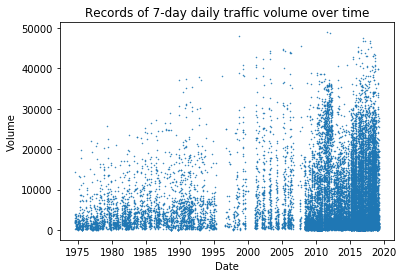

In [12]:
plt.plot(df_road['adt'], '.', markersize = 1)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title("Records of 7-day daily traffic volume over time")
plt.savefig('images/volume_change_over_time.png')
# can see an increase in the maximum traffic volume sampled over the years
# peak at around 2012 but might be outliers

In [13]:
# take a closer look at data after 2010
df_after2010 = df_road[df_road.index > "2010-01-01"]
df_after2010.shape

(15498, 5)

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Volume')

Text(0.5, 1.0, 'Records of 7-day daily traffic volume after 2010')

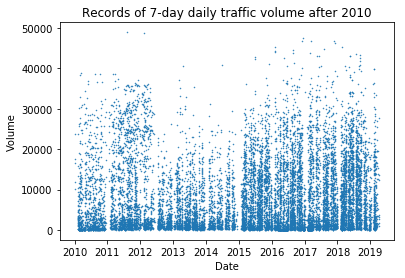

In [14]:
plt.plot(df_after2010['adt'], '.', markersize = 1)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title("Records of 7-day daily traffic volume after 2010")
plt.savefig('images/volume_change_over_time_after_2010.png')
# there are some outliers around 2011-2012 with volumes approaching 50000,
# and the volumes decreases dramatically after around mid year of 2012 then gradually increase
# over time. 

In [15]:
# print the details of the outliers
temp = df_after2010[df_after2010.index < '2013-01-01']
temp = temp[temp['adt']>45000]
temp  # remove all south easter highway data

,road_name,adt,latitude,longitude,sampling_count
count_date,,,,,
2011-08-04,GREAT NORTH RD (CWC),48941.0,-36.875827,174.704014,2
2012-02-07,GREAT NORTH RD (CWC),48730.0,-36.875827,174.704014,2


(array([1033., 1299.,  931., 1269.,  787., 1386., 2162., 2233., 2228.,
        2170.]),
 array([733776. , 734114.2, 734452.4, 734790.6, 735128.8, 735467. ,
        735805.2, 736143.4, 736481.6, 736819.8, 737158. ]),
 <a list of 10 Patch objects>)

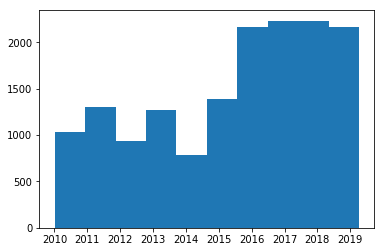

In [16]:
# sampling frequency
plt.hist(df_after2010.index)
# can see that the sampling freqency increased by around 500 after 2016 
# (but we don't see dramatic increase in traffic volume)

In [17]:
# label encoding coordinates - sort by max adt
df_after2010['coord'] = df_after2010['latitude'].map(str) +","+ df_after2010['longitude'].map(str)
df_after2010['coord'].head()

count_date
2010-01-04     -36.77766580117253,174.77510750639811
2010-01-04     -36.81080767101732,174.71248126068556
2010-01-04     -36.72092933262911,174.72395301584473
2010-01-04      -36.80286964341332,174.7876039215321
2010-01-04    -36.794472356470266,174.72389650228283
Name: coord, dtype: object

In [18]:
# get a maximum historical count at each coord
df_after2010['max_adt'] = df_after2010.groupby('coord')['adt'].transform(max)
df_after2010['max_adt'].head()

count_date
2010-01-04    17379.0
2010-01-04    21856.0
2010-01-04    14225.0
2010-01-04    32902.0
2010-01-04    21435.0
Name: max_adt, dtype: float64

In [19]:
df_after2010.sort_values(by = 'max_adt', inplace = True)
# df_after2010['adt_ordered_index'] = pd.Series(range(len(df_after2010)))
df_after2010.reset_index(inplace = True)
# df_after2010['coord'] = df_after2010['coord'].astype('category')
# df_after2010['coord'] = df_after2010['coord'].cat.codes

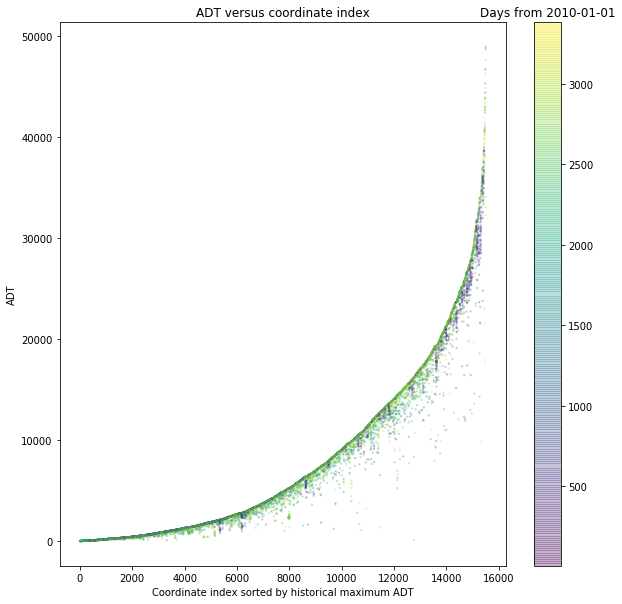

In [20]:
from datetime import datetime 
# overview of ordered traffic volume
def temp_plot(df, c, figname = 'temp.png'):
    fig, ax = plt.subplots(figsize = (10,10))
    img = ax.scatter(x = df.index, y = df.adt, 
                c = c, alpha = 0.3, edgecolors='none', s = 5)
    # ax.legend()
    plt.title('ADT versus coordinate index')
    plt.xlabel('Coordinate index sorted by historical maximum ADT')
    plt.ylabel('ADT')
    clb = plt.colorbar(img, ax = ax)
    clb.ax.set_title('Days from 2010-01-01')
    plt.savefig(figname)
    plt.show()
    
# c = df_after2010['count_date'].astype(np.int64) // 10 ** 9

c = (df_after2010['count_date'] - pd.to_datetime('2010-01-01')).dt.days
temp_plot(df_after2010, c, 'images/ADT_sorted_by_location.png')

# some sites have outliers/high variance 

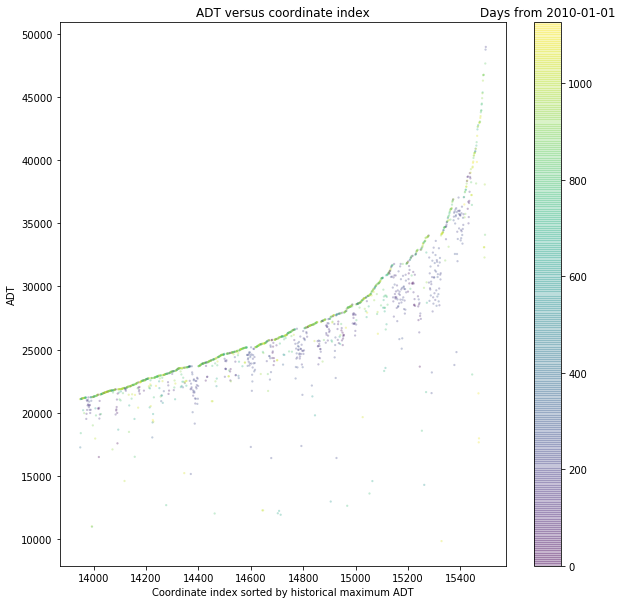

In [21]:
# closer look at high volume sites (90 percentile cut)
temp = df_after2010[df_after2010['max_adt']>np.percentile(df_after2010['max_adt'], 90)]
c = (temp['count_date'] - pd.to_datetime('2010-01-01')).dt.days
# c = temp['count_date'].astype(np.int64) // 10 ** 9
c = (c - min(c))/min(c)
temp_plot(temp, c)

Most of the time the maximum adt is also the latest record

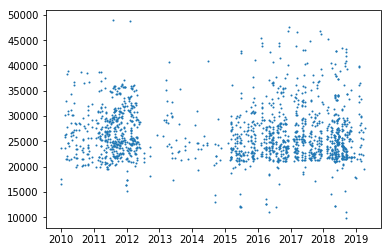

In [22]:
plt.scatter(x = temp.count_date, y = temp['adt'], s=1)

Text(0.5, 0, 'Coordinate index sorted by increasing maximum ADT')

Text(0, 0.5, 'Date')

Text(0.5, 1.0, 'Date versus coordinate index')

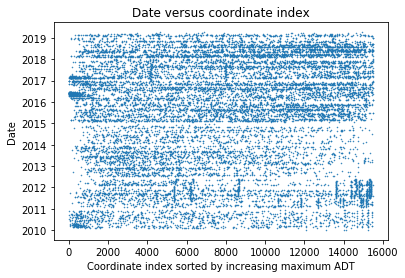

In [23]:
plt.plot(df_after2010.count_date, '.', markersize =1)
plt.xlabel('Coordinate index sorted by increasing maximum ADT')
plt.ylabel('Date')
plt.title('Date versus coordinate index')
plt.savefig('images/date_vs_coord.png')

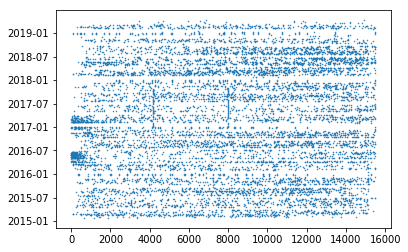

In [24]:
# take a closer look from 2015
temp = df_after2010[df_after2010.count_date > '2015']
plt.plot(temp.count_date, '.', markersize =1)

The sampling pattern varies over time. 

2015 2016


(174.44011265942981, 175.11153905099715)

(-37.22396918003958, -36.23412310649898)

Text(0.5, 0, 'Lontitude')

Text(0, 0.5, 'Latitude')

2016 2017


(174.44011265942981, 175.11153905099715)

(-37.22396918003958, -36.23412310649898)

Text(0.5, 0, 'Lontitude')

Text(0, 0.5, 'Latitude')

2017 2018


(174.44011265942981, 175.11153905099715)

(-37.22396918003958, -36.23412310649898)

Text(0.5, 0, 'Lontitude')

Text(0, 0.5, 'Latitude')

2018 2019


(174.44011265942981, 175.11153905099715)

(-37.22396918003958, -36.23412310649898)

Text(0.5, 0, 'Lontitude')

Text(0, 0.5, 'Latitude')

Text(0.5, 1.0, 'ADT')

Text(0.5, 0.98, 'Yearly ADT and cooredinates')

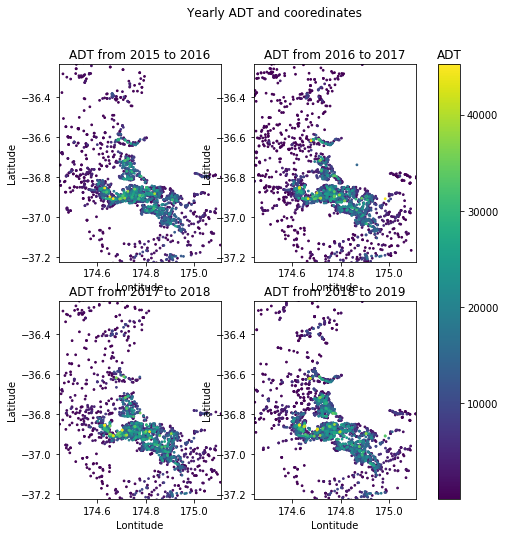

In [25]:
# look at longitude, latitude, color by adt from 2015 to 2019
years = ['2015', '2016', '2017', '2018', '2019']
fig, axes = plt.subplots(2,2, figsize = (8,8))
x_range = np.percentile(df_after2010.longitude, [1, 99])
y_range = np.percentile(df_after2010.latitude, [1, 99])
for i, item in enumerate(years):
    if i +1 == len(years):
        break
    y = years[i]
    next_y = years[i+1] 
    print(y, next_y)
    temp = df_after2010[(df_after2010['count_date'] > y) & (df_after2010['count_date'] < next_y)]
    ax = axes.flat[i]
    img = ax.scatter(x = temp['longitude'], y = temp['latitude'], c = temp['adt'], s=3)
    ax.title.set_text(f'ADT from {y} to {next_y}')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_xlabel('Lontitude')
    ax.set_ylabel('Latitude')
    
clb = fig.colorbar(img, ax = axes.ravel().tolist())
clb.ax.set_title('ADT')
plt.suptitle('Yearly ADT and cooredinates')
plt.savefig('images/Yearly_ADT_and_cooredinates.png')
plt.show()    
plt.close()

Observe slight changes of the traffic volume/traffic count location

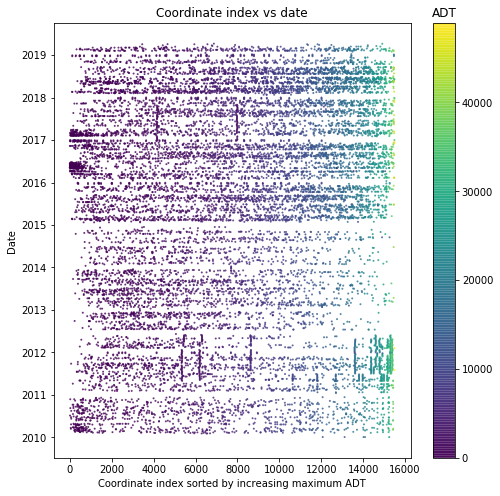

In [26]:
def temp_plot(df, figname = 'images/temp.png', marker_size = 4, fs = (8,8)):
    fig, ax = plt.subplots(figsize = fs)
    img = ax.scatter(x = df.index, y =  df['count_date'],
                c = df['adt'], alpha = 0.8, edgecolors='none', s = marker_size)
    plt.title("Coordinate index vs date")
    plt.ylabel("Date")
    plt.xlabel('Coordinate index sorted by increasing maximum ADT')
    clb = plt.colorbar(img, ax = ax)
    clb.ax.set_title('ADT')
    plt.savefig(figname)
    plt.show()
temp_plot(df_after2010, 'images/date_vs_coord_colored_by_ADT.png')

There seem to be some change in sampling frequency or in traffic volume before and after 2015

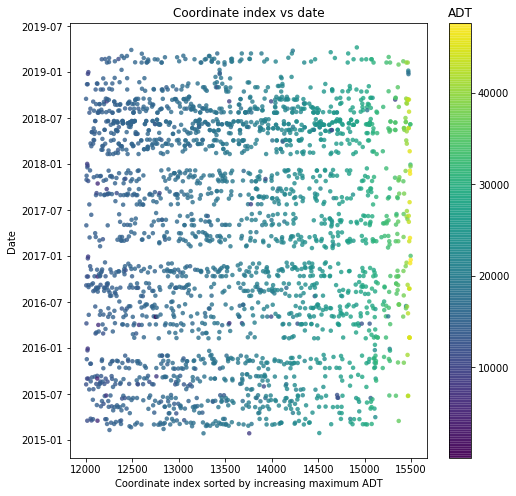

In [27]:
# try only after 2017
temp = df_after2010[df_after2010.count_date > '2015-01-01']
temp = temp[temp.index > 12000]
temp_plot(temp, 'images/date_vs_coord_colored_by_ADT_subset.png', marker_size= 20, fs=(8,8))

Text(0.5, 0, 'coordinate index sorted by maximum ADT')

Text(0, 0.5, 'Number of historical traffic counts')

Text(0.5, 1.0, 'Number of historical traffic counts versus coordinates')

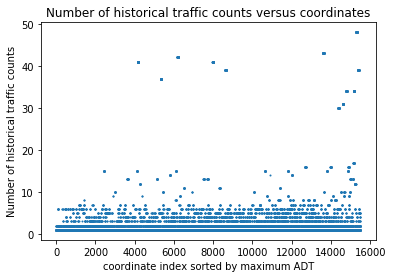

In [28]:
plt.scatter(x = df_after2010.index, y = df_after2010.sampling_count, s=1)
plt.xlabel('coordinate index sorted by maximum ADT')
plt.ylabel('Number of historical traffic counts')
plt.title('Number of historical traffic counts versus coordinates')
plt.savefig('images/sampling_count_vs_coord.png')
plt.show()

Text(0.5, 0, 'Coordinate index with historical sampling count > 10')

Text(0, 0.5, 'ADT')

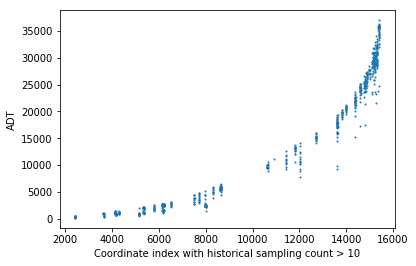

In [29]:
# look at adt vs sample_count (see if there is a coorelation)
temp = df_after2010[df_after2010.sampling_count > 10]
plt.scatter(x = temp.index, y = temp.adt, s=1)
plt.xlabel('Coordinate index with historical sampling count > 10')
plt.ylabel('ADT')
plt.savefig('images/index_with_filtered_sampling_count.png')
plt.show()
# seens like there are some pattern

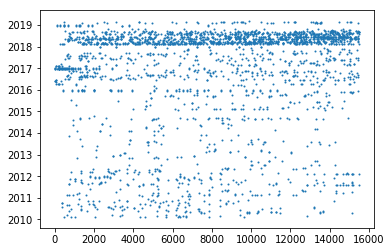

In [30]:
temp = df_after2010[df_after2010['sampling_count']==2]
plt.scatter(x = temp.index, y = temp.count_date, s = 1)

More records from 2018 for locations with 2 historical traffic counts

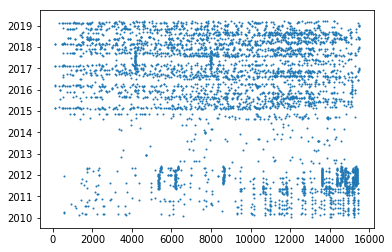

In [31]:
temp = df_after2010[df_after2010['sampling_count']>2]
plt.scatter(x = temp.index, y = temp.count_date, s= 1)

More records for 'sampling_count' > 2 become more dense/better sampled after 2015

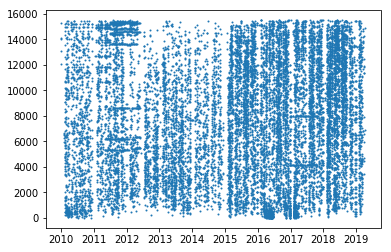

In [32]:
# explore correlation between sampling date and coord
plt.scatter(x = df_after2010['count_date'], y = df_after2010.index, s = 1)

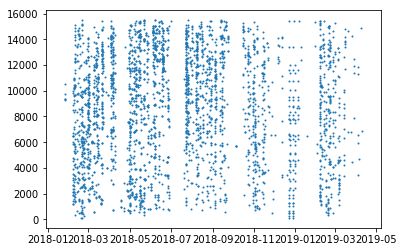

In [33]:
# closer look
temp = df_after2010[df_after2010.count_date > '2018']
plt.scatter(x = temp['count_date'], y = temp.index, s = 1)

In [34]:
df_after2010.columns

Index(['count_date', 'road_name', 'adt', 'latitude', 'longitude',
       'sampling_count', 'coord', 'max_adt'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CECBD68>,
      dtype=object)

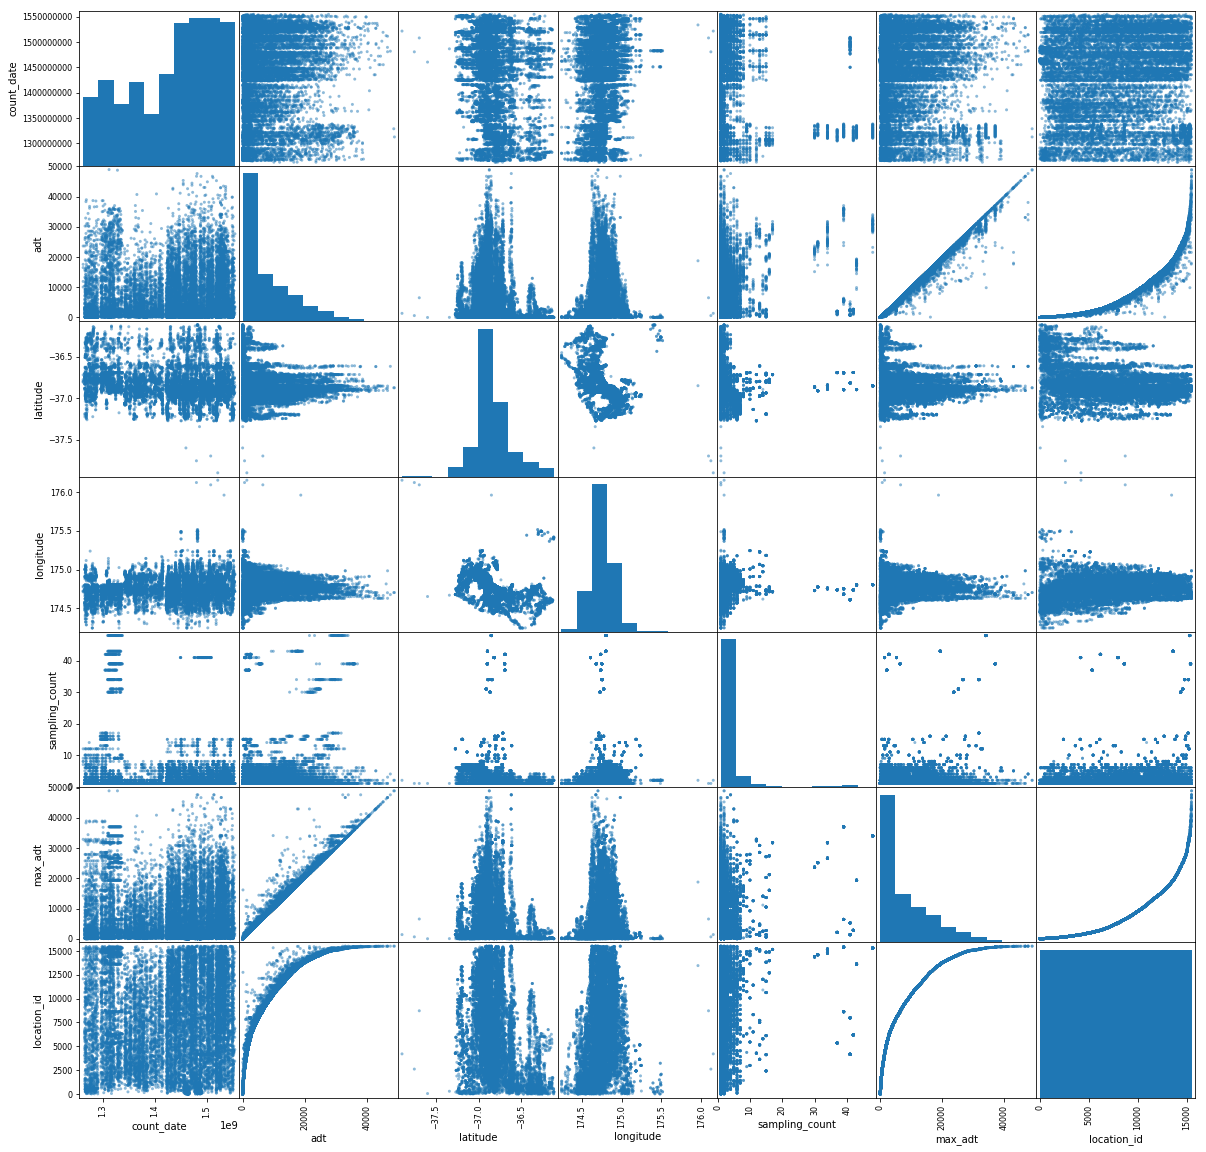

In [35]:
temp = df_after2010[['count_date', 'adt', 'latitude', 'longitude',
       'sampling_count', 'max_adt']]
temp['count_date'] = temp['count_date'].astype(np.int64) // 10 ** 9
temp['location_id'] = df_after2010.index
pd.plotting.scatter_matrix(temp, figsize=(20, 20))

# Summary
In this notebook we explore the traffic count data. The goal is to understand the data and find insights that will help us quantify the change of traffic volume at Auckland from 2010. 

Conducting statistical testing on the given data is difficult (if at all possible). There is no reason to believe the observations drawn from the data are independent and identically distributed. Although the location of traffic count seems reasonably well distributed accross Auckland, the temporal effects (e.g. seasonality) makes it hard to find samples that can be compared fairly (while being large enough to represent Auckland traffic data). 


